In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklego.meta import ZeroInflatedRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
plt.style.use('fivethirtyeight')

In [3]:
#Read in the data and convert dates to date time objects in UTC 
noaa_utc = pd.read_csv('cleaned_storm_data.csv', parse_dates=[10, 12], date_parser = lambda col: pd.to_datetime(col, utc=True))


In [4]:
#Create a new column representing the length of the storm event
noaa_utc['duration'] = noaa_utc['End_datetime'] - noaa_utc['Start_datetime']

In [16]:
noaa_utc['State'].replace(to_replace=['WASHINGTON', 'OREGON'], value='PNW', inplace=True)
noaa_utc['State'].replace(to_replace=['NEVADA', 'UTAH', 'ARIZONA', 'NEW MEXICO'], value='Southwest', inplace=True)
noaa_utc['State'].replace(to_replace=['IDAHO', 'MONTANA', 'COLORADO', 'WYOMING'], value='Rockies', inplace=True)
noaa_utc['State'].replace(to_replace=['NORTH DAKOTA', 'SOUTH DAKOTA', 'NEBRASKA', 'KANSAS',
                                      'MINNESOTA', 'IOWA', 'MISSOURI', 'WISCONSIN', 'ILLINOIS',
                                      'INDIANA', 'OHIO', 'MICHIGAN'
                                     ], value='Midwest', inplace=True)
noaa_utc['State'].replace(to_replace=['OKLAHOMA', 'ARKANSAS', 'LOUISIANA', 'MISSISSIPPI', 'TENNESSEE',
                                      'KENTUCKY', 'ALABAMA', 'GEORGIA', 'NORTH CAROLINA', 'SOUTH CAROLINA', 'VIRGINIA',
                                      'WEST VIRGINIA', 'MARYLAND'
                                     ], value='South', inplace=True)
noaa_utc['State'].replace(to_replace=['DELAWARE', 'NEW JERSEY', 'PENNSYLVANIA', 'NEW YORK', 'CONNECTICUT',
                                      'MASSACHUSETTS', 'RHODE ISLAND', 'VERMONT', 'NEW HAMPSHIRE', 'MAINE'
                                     ], value='Northeast', inplace=True)
noaa_utc['State'].replace(to_replace=['GULF OF MEXICO', 'ATLANTIC NORTH', 'ATLANTIC SOUTH', 'E PACIFIC', 
                                      'HAWAII WATERS', 'GULF OF ALASKA'
                                     ], value='Ocean', inplace=True)
noaa_utc['State'].replace(to_replace=['LAKE MICHIGAN', 'LAKE HURON', 'LAKE SUPERIOR', 'LAKE ERIE', 
                                      'LAKE ONTARIO', 'LAKE ST CLAIR'
                                     ], value='Great Lakes', inplace=True)
noaa_utc['State'].replace(to_replace=['GUAM', 'VIRGIN ISLANDS', 'AMERICAN SAMOA', 'PUERTO RICO', 'DISTRICT OF COLUMBIA'], value='Territories', inplace=True)

In [135]:
#Convert categorical weather type column into numerical data via One Hot Encoding 
oe_style = OneHotEncoder()
# oe_results_weather = oe_style.fit_transform(noaa_utc[["Weather_type"]])
# noaa_utc = noaa_utc.join(pd.DataFrame(oe_results_weather.toarray(), columns=oe_style.categories_))

# oe_results_state = oe_style.fit_transform(noaa_utc[["State"]])
# noaa_utc = noaa_utc.join(pd.DataFrame(oe_results_state.toarray(), columns=oe_style.categories_))

# oe_results_county = oe_style.fit_transform(noaa_utc[["County"]])
# noaa_utc = noaa_utc.join(pd.DataFrame(oe_results_county.toarray(), columns=oe_style.categories_))

# oe_results_county_type = oe_style.fit_transform(noaa_utc[["County_type"]])
# noaa_utc = noaa_utc.join(pd.DataFrame(oe_results_county_type.toarray(), columns=oe_style.categories_))



In [18]:
#Check to make sure everything worked and what it looks like 
# noaa_utc['County_type'].value_counts()
noaa_utc['Weather_type'].value_counts()

Thunderstorm Wind             386990
Hail                          307598
Flash Flood                    96353
High Wind                      82146
Winter Storm                   81607
Winter Weather                 70906
Heavy Snow                     67770
Drought                        66888
Flood                          62110
Tornado                        37299
Marine Thunderstorm Wind       35840
Heavy Rain                     28924
Heat                           25313
Strong Wind                    24131
Lightning                      17414
Cold/Wind Chill                15586
Blizzard                       15185
Dense Fog                      15111
Extreme Cold/Wind Chill        14197
Frost/Freeze                   13714
Ice Storm                      11854
Excessive Heat                 11662
High Surf                      10282
Funnel Cloud                    9242
Wildfire                        8299
Tropical Storm                  6271
Waterspout                      5653
C

# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [193]:
split_date = 2015
noaa_train = noaa_utc.loc[noaa_utc.Year <= split_date].copy()
noaa_test = noaa_utc.loc[noaa_utc.Year > split_date].copy()

# Create Time Series Features

In [191]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.Start_datetime
    df['hour'] = df['date'].dt.hour
    df['length'] = df['duration'].dt.total_seconds()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['Deaths_direct', 'Deaths_indirect', 'Injuries_direct', 'Injuries_indirect', 'Crop_damage'
    # ,'hour','dayofweek','quarter','month','year',
    #         'dayofyear','dayofmonth','weekofyear'
            ]]

           
    if label:
        y = df[label]
        return X, y
    return X

In [194]:
#divy things up into train and test splits
X_train, y_train = create_features(noaa_train, label='Property_damage')
X_test, y_test = create_features(noaa_test, label='Property_damage')

C:\Users\apanc\AppData\Local\Temp\ipykernel_15880\1022980482.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\apanc\AppData\Local\Temp\ipykernel_15880\1022980482.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [78]:
y_train.value_counts()

0      1120018
1         5356
2          856
3          234
4          109
5           55
6           49
7           25
8           19
10          14
14          11
9           10
12           9
11           9
13           8
16           5
27           4
23           4
19           3
20           3
17           3
22           2
24           2
18           2
30           2
32           2
15           2
25           2
158          1
44           1
21           1
34           1
93           1
140          1
638          1
97           1
56           1
35           1
58           1
43           1
Name: Deaths_direct, dtype: int64

# Create XGBoost Model

In [220]:
zir = ZeroInflatedRegressor(
    classifier=RandomForestClassifier(),
    regressor=RandomForestRegressor()
)

zir.fit(X_train, y_train)

In [195]:
reg = xgb.XGBRegressor(base_score=0)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
       ) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [209]:
# plt.scatter(x=noaa_test['Property_damage'], y=noaa_test['PD_Prediction'])
zir.score(X_test, y_test)

0.09775890207453852

## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.


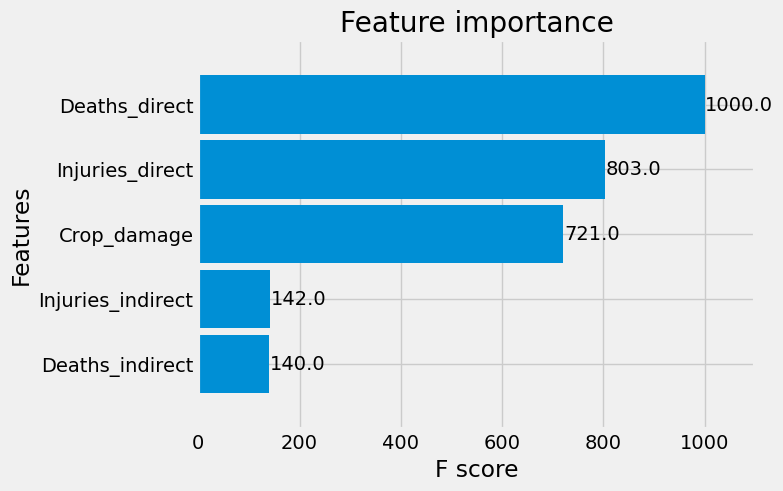

In [197]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [210]:
#Create a column in the test set to represent the predicted property damage 
noaa_test['PD_Prediction'] = zir.predict(X_test)

In [211]:
noaa_test['PD_Prediction']

1126830    0.0
1126831    0.0
1126832    0.0
1126833    0.0
1126834    0.0
          ... 
1549401    0.0
1549402    0.0
1549403    0.0
1549404    0.0
1549405    0.0
Name: PD_Prediction, Length: 422576, dtype: float64

# Error Metrics On Test Set
Our RMSE error is 1770114798485055.2 (might be due to high count of 0's in dataset)
Our MAE error is 508313.69  
Our MAPE error is 2.26%

In [212]:
mean_squared_error(y_true=noaa_test['Property_damage'],
                   y_pred=noaa_test['PD_Prediction'])

1583529317814342.5

In [213]:
mean_absolute_error(y_true=noaa_test['Property_damage'],
                   y_pred=noaa_test['PD_Prediction'])

487358.9381855459

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.


In [214]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_true=noaa_test['Property_damage'],
                   y_pred=noaa_test['PD_Prediction'])

1.7862430535410054e+20

# Look at Worst and Best Predicted Days

In [215]:
noaa_test['error'] = noaa_test['Property_damage'] - noaa_test['PD_Prediction']
noaa_test['abs_error'] = noaa_test['error'].apply(np.abs)
error_by_day = noaa_test.groupby(['year','month','dayofmonth']) \
    .mean()[['Property_damage','PD_Prediction','error','abs_error']]

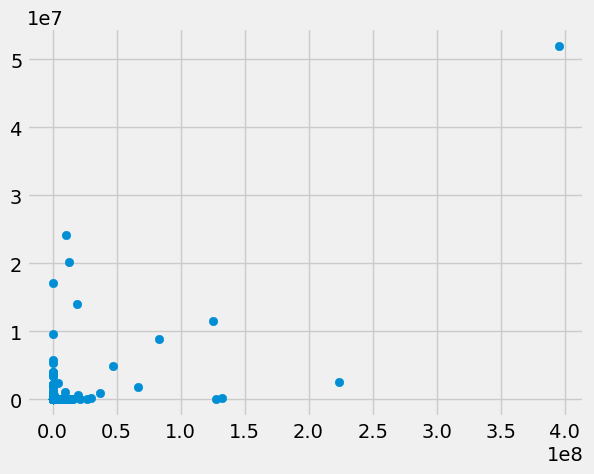

In [216]:
plt.scatter(x=error_by_day['Property_damage'], y=error_by_day['PD_Prediction'])

In [217]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

Property_damage  PD_Prediction         error  \
year month dayofmonth                                                 
2022 6     27             6.394366e+03   1.710209e+07 -1.709570e+07   
2017 9     9              1.027669e+07   2.418591e+07 -1.390923e+07   
2021 6     26             7.088112e+05   9.534002e+06 -8.825190e+06   
2016 10    9              1.271267e+07   2.022068e+07 -7.508017e+06   
     6     19             3.743925e+04   5.709608e+06 -5.672169e+06   
2022 3     3              2.631579e+02   5.276515e+06 -5.276252e+06   
2016 7     22             5.555449e+03   3.992083e+06 -3.986528e+06   
2018 7     24             1.661899e+04   3.951839e+06 -3.935220e+06   
2022 6     9              5.013072e+03   3.682192e+06 -3.677179e+06   
2021 12    10             1.066761e+05   3.772747e+06 -3.666071e+06   

                          abs_error  
year month dayofmonth                
2022 6     27          1.710848e+07  
2017 9     9           3.439038e+07  
2021 6     26          1.022715e+07  
2016 10    9           2.293752e+07  
     6     19          5.747047e+06  
2022 3     3           5.276252e+06  
2016 7     22          3.997636e+06  
2018 7     24          3.968458e+06  
2022 6     9           3.687205e+06  
2021 12    10          3.822190e+06

Seems like October had a lot of overforecasted days

In [218]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

Property_damage  PD_Prediction         error  \
year month dayofmonth                                                 
2018 11    8              3.953489e+08   5.197706e+07  3.433718e+08   
2017 8     26             2.238928e+08   2.571817e+06  2.213210e+08   
           27             1.325063e+08   1.371214e+05  1.323692e+08   
     9     20             1.277204e+08   0.000000e+00  1.277204e+08   
2020 8     26             1.251421e+08   1.156505e+07  1.135771e+08   
2018 10    24             8.339583e+07   8.931689e+06  7.446414e+07   
2017 8     25             6.667526e+07   1.834082e+06  6.484118e+07   
2021 8     29             4.701001e+07   4.844341e+06  4.216567e+07   
2022 9     28             3.731205e+07   8.563861e+05  3.645566e+07   
2017 9     9              1.027669e+07   2.418591e+07 -1.390923e+07   

                          abs_error  
year month dayofmonth                
2018 11    8           3.433718e+08  
2017 8     26          2.213210e+08  
           27          1.323784e+08  
     9     20          1.277204e+08  
2020 8     26          1.135771e+08  
2018 10    24          7.459352e+07  
2017 8     25          6.485118e+07  
2021 8     29          4.754929e+07  
2022 9     28          3.816843e+07  
2017 9     9           3.439038e+07

The best predicted days seem to be in the fall and early winter months

In [219]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

Property_damage  PD_Prediction  error  abs_error
year month dayofmonth                                                  
2017 12    2                       0.0            0.0    0.0        0.0
2019 12    6                       0.0            0.0    0.0        0.0
2018 10    18                      0.0            0.0    0.0        0.0
2022 2     10                      0.0            0.0    0.0        0.0
2017 10    19                      0.0            0.0    0.0        0.0
     12    18                      0.0            0.0    0.0        0.0
2019 12    18                      0.0            0.0    0.0        0.0
           19                      0.0            0.0    0.0        0.0
2021 12    27                      0.0            0.0    0.0        0.0
2020 3     8                       0.0            0.0    0.0        0.0